# Bayes' Based Classifiers

We will now introduce a series of classification algorithms based on Bayes' rule from probability theory.

## What we will accomplish

In this notebook we will:
- Review Bayes' rule,
- Introduce a classification model framework for the three models we consider,
- Reintroduce the iris data set and
- Demonstrate:
    - Linear discriminant analysis,
    - Quadratic discriminant analysis and
    - Na&#xEF;ve Bayes.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## Review of Bayes' rule

Assume that we have some probability space, $\Omega$.

### Conditional probability

Remember that for events $A$ and $B$ with $P(B)\neq0$ we define the probability of $A$ conditional on $B$ as:

$$
P(A|B) = \frac{P(A\cap B)}{P(B)}.
$$

This definition can be visualized with this graphic:

<img src="cond_prob.png" width="40%"></img>

### Law of total probability

If $B_1, \ B_2, \dots, B_n$ are disjoint events such that $\cup_{i=1}^n B_i= \Omega$, then it holds that:

$$
P(A) = \sum_{i=1}^n P(A \cap B_i),
$$

for any event $A$.

The law of total probability can be visualized with this graphic:

<img src="tot_prob.png" width="40%"></img>

### Bayes' rule

For events $A$ and $B$ with $P(B)\neq0$, then Bayes' rule (or the Bayes–Price theorem) is

$$
P(A|B) = \frac{P(B|A) P(A)}{P(B)}.
$$

This is sometimes taken a step further using the law of total probability for example:

$$
P(A|B) = \frac{P(B|A) P(A)}{P(B \cap A) + P(B \cap A^c)} = \frac{P(B|A) P(A)}{P(B|A)P(A) + P(B|A^c)P(A^c)},
$$

where $A^c = \Omega - A$.

For a nice visualization of conditional probability and Baye's rule check out this blog post, <a href="https://oscarbonilla.com/2009/05/visualizing-bayes-theorem/">https://oscarbonilla.com/2009/05/visualizing-bayes-theorem/</a>.

## Using Bayes' rule for classification

Suppose we have a set of $m$ features collected in a matrix $X$ and an output variable $y$ that can take on any of $\mathcal{C}$ possible categories.

In the case of logistic regression, $\mathcal{C} = 2$, and we modeled:

$$
P(y=1|X=X^*),
$$

in order to make predictions.

However, we can use Bayes' rule to rewrite this expression like so:

$$
P(y=c|X=X^*) = \frac{\pi_c f_c(X^*)}{\sum_{l=1}^\mathcal{C} \pi_l f_l(X^*)},
$$

where $\pi_c$ denotes the <i>prior</i> probability that a random observation comes from the $c^\text{th}$ class and $f_c(X) \equiv P(X|y=c)$ (<i>note this form assumes that $X$ is a qualitative variable, but is easily rewritten if $X$ is continuous</i>).

When fitting this model we estimate the $\pi_l$s by simply taking the fraction of the sample set belonging to each of the $\mathcal{C}$ classes. However, for the $f_l(X)$s, we have to make some assumptions.


Different assumptions on the $f_l(X)$s result in different algorithms. We will present three models that follow from three different assumptions.

### A return to the `iris` data set

In this notebook we will illustrate the algorithms with our trusty `iris` data set, which provides four measurements (sepal length, sepal width, petal length and petal width) for $150$ irises of three distinct types ($50$ for each type).

We load this data set now.

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [3]:
iris = load_iris(as_frame=True)

X = iris['data']
X = X.rename(columns={'sepal length (cm)':'sepal_length',
                         'sepal width (cm)':'sepal_width',
                         'petal length (cm)':'petal_length',
                         'petal width (cm)':'petal_width'})
y = iris['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y,
                                                       shuffle=True,
                                                       random_state=413,
                                                       test_size=.2,
                                                       stratify=y)

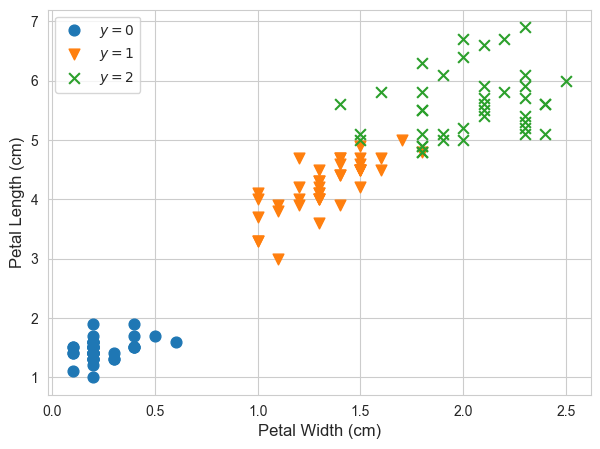

In [5]:
plt.figure(figsize=(7,5))

plt.scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                s=60,
                label='$y=0$')
plt.scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                s=60,
                marker = 'v',
                label='$y=1$')
plt.scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                s=60,
                marker = 'x',
                label='$y=2$')

plt.xlabel("Petal Width (cm)", fontsize=12)
plt.ylabel("Petal Length (cm)", fontsize=12)
plt.legend(fontsize=10)

plt.show()

## Linear discriminant analysis (LDA)

The first model we discuss is know as <i>linear discriminant analysis</i> or LDA. Note that LDA is an ambiguous acronym in data science/machine learning because it can also stand for latent Dirichlet allocation, but in these notes we will use it to refer to linear discriminant analysis.

### Model assumption

In LDA we will assume that $X|y=c$ is Gaussian. What that means is dependent upon the number of features, $m$.

#### A single feature, $m=1$

For a single feature we assume that 

$$
f_c(X) = \frac{1}{\sqrt{2\pi}\sigma_c} \exp \left( -\frac{1}{2\sigma_c^2} (X - \mu_c)^2 \right),
$$

which is the probability density function of a normal random variable with mean $\mu_c$ and standard deviation $\sigma_c$. In linear discriminant analysis we assume that $\sigma_1 = \sigma_2 = \dots = \sigma_\mathcal{C} = \sigma$.

This assumption leads to the following estimate of $P(y=c|X)$

$$
P(y=c|X) = \frac{\pi_c \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{1}{2\sigma^2}(X-\mu_c)^2\right)}{\sum_{l=1}^\mathcal{C} \pi_l \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{1}{2\sigma^2}(X-\mu_l)^2\right)}.
$$

In this setting we would estimate $\mu_c$ and $\sigma$ with the following formulae:

$$
\hat{\mu}_c = \frac{1}{n_c} \sum_{i:y_i = c} X_i,
$$

$$
\hat{\sigma}^2 = \frac{1}{n-\mathcal{C}} \sum_{c=1}^\mathcal{C} \sum_{i:y_i = c}(X_i - \hat{\mu}_c)^2.
$$

#### Making classifications

We typically make classifications in this setting by choosing the class, $c$, for which $P(y=c|X)$ is largest, through some algebra and $\log$ manipulations you can show that this is equivalent to choosing the class, $c$, for which the <i>discriminant function</i> is largest where:

$$
\delta_c = X \frac{\mu_c}{\sigma^2} - \frac{\mu_c^2}{2\sigma^2} + \log\left(\pi_c\right)
$$

is the discriminant function for class $c$. <i>We estimate this function with the $\hat{\mu}_c$s and $\hat{\sigma}$.</i>

Let's apply this to our iris data set. We will use petal length as our single feature for this LDA model.

LDA is implemented in `sklearn` with `LinearDiscriminantAnalysis`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html">https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html</a>.

In [6]:
## Import linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
## Make the model object
LDA = LinearDiscriminantAnalysis()

## Fit the object 
LDA.fit(X_train['petal_length'].values.reshape(-1,1), y_train)

LinearDiscriminantAnalysis()

In [8]:
## Demonstrate predict_proba
LDA.predict_proba(X_train['petal_length'].values.reshape(-1,1))

array([[7.10431379e-13, 8.25288597e-01, 1.74711403e-01],
       [7.81579342e-22, 2.89831132e-03, 9.97101689e-01],
       [3.40252050e-10, 9.89120399e-01, 1.08796008e-02],
       [1.52997990e-09, 9.94776022e-01, 5.22397645e-03],
       [1.00000000e+00, 8.93683315e-11, 2.29039518e-22],
       [1.00000000e+00, 8.93683315e-11, 2.29039518e-22],
       [1.16208611e-27, 3.44241499e-05, 9.99965576e-01],
       [9.99999286e-01, 7.13898207e-07, 1.54486477e-16],
       [7.29615856e-21, 6.05142144e-03, 9.93948579e-01],
       [8.35862055e-23, 1.38584735e-03, 9.98614153e-01],
       [1.64159917e-11, 9.53966628e-01, 4.60333719e-02],
       [1.00000000e+00, 3.99569633e-10, 2.14490048e-21],
       [9.99999998e-01, 1.78649292e-09, 2.00864817e-20],
       [4.24515550e-16, 1.97066413e-01, 8.02933587e-01],
       [6.78772009e-20, 1.25915222e-02, 9.87408478e-01],
       [8.35862055e-23, 1.38584735e-03, 9.98614153e-01],
       [3.27013149e-15, 3.39527848e-01, 6.60472152e-01],
       [1.00000000e+00, 8.93683

#### Demonstrating what LDA is doing

In [9]:
## defining the discriminant function
def delta_c(x, mu_hat, sigma_hat_sq, pi_c):
    return x*(mu_hat/sigma_hat_sq) - mu_hat**2/(2*sigma_hat_sq) + np.log(pi_c)

In [10]:
## First we estimate the means of the three normal distributions
mu_0_hat = np.mean(X_train.loc[y_train==0].petal_length)
mu_1_hat = np.mean(X_train.loc[y_train==1].petal_length)
mu_2_hat = np.mean(X_train.loc[y_train==2].petal_length)

## Then the common variance
sigma_hat_sq = np.sum(np.power(X_train.loc[y_train==0].petal_length - mu_0_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(X_train.loc[y_train==1].petal_length - mu_1_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(X_train.loc[y_train==2].petal_length - mu_2_hat,2))
sigma_hat_sq = sigma_hat_sq/(len(y_train)-3)

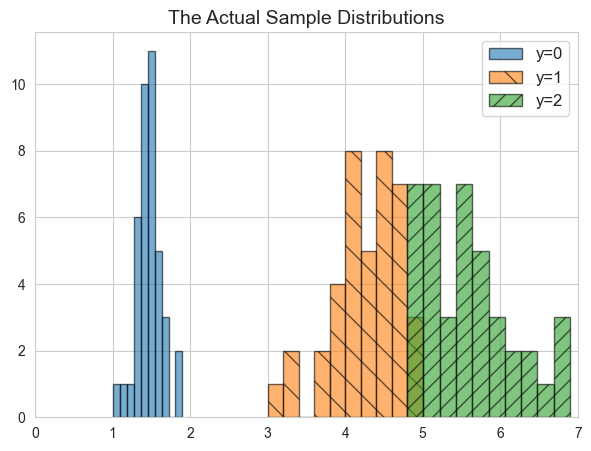

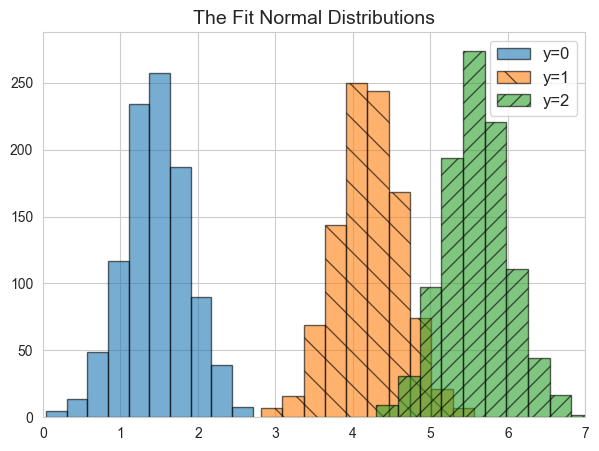

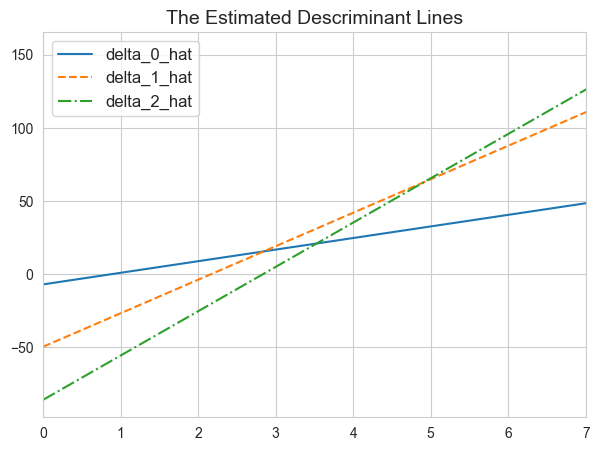

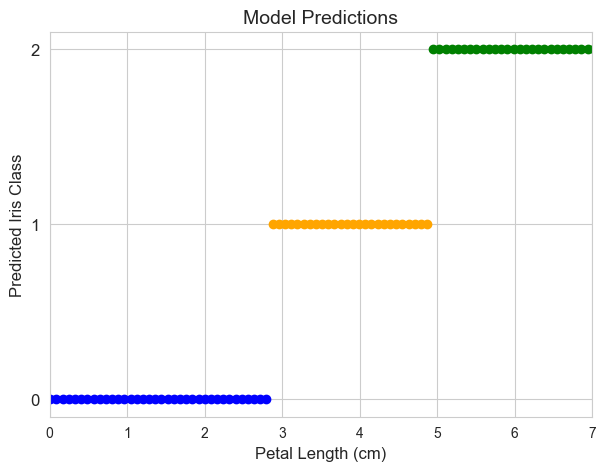

In [11]:
## Plot the sample distributions
plt.figure(figsize=(7,5))

plt.hist(X_train.loc[y_train==0].petal_length,alpha=.6, 
         label="y=0",
         edgecolor="black")
plt.hist(X_train.loc[y_train==1].petal_length,alpha=.6, 
         label="y=1",
         hatch = "\\",
         edgecolor="black")
plt.hist(X_train.loc[y_train==2].petal_length,alpha=.6, 
         label="y=2",
         hatch='//',
         edgecolor="black")

plt.legend(fontsize=12)
plt.title("The Actual Sample Distributions", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0,7)

plt.show()

## Plot the fit normal distributions
plt.figure(figsize=(7,5))

plt.hist(np.sqrt(sigma_hat_sq)*np.random.randn(1000)+mu_0_hat,alpha=.6, 
         label="y=0",
         edgecolor="black")
plt.hist(np.sqrt(sigma_hat_sq)*np.random.randn(1000)+mu_1_hat,alpha=.6, 
         label="y=1",
         hatch='\\',
         edgecolor="black")
plt.hist(np.sqrt(sigma_hat_sq)*np.random.randn(1000)+mu_2_hat,alpha=.6, 
         label="y=2",
         hatch='//',
         edgecolor="black")

plt.legend(fontsize=12)
plt.title("The Fit Normal Distributions", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0,7)


plt.show()

## Plot the discriminant lines
plt.figure(figsize=(7,5))

plt.plot(np.linspace(X_train.petal_width.min()-1,
                        X_train.petal_length.max()+1,100),
        delta_c(np.linspace(X_train.petal_width.min()-1,
                        X_train.petal_length.max()+1,100), mu_0_hat, sigma_hat_sq, 1/3),
            label="delta_0_hat")

plt.plot(np.linspace(X_train.petal_length.min()-1,
                        X_train.petal_length.max()+1,100),
        delta_c(np.linspace(X_train.petal_length.min()-1,
                        X_train.petal_length.max()+1,100), mu_1_hat, sigma_hat_sq, 1/3),
            '--',
            label="delta_1_hat")


plt.plot(np.linspace(X_train.petal_length.min()-1,
                        X_train.petal_length.max()+1,100),
        delta_c(np.linspace(X_train.petal_length.min()-1,
                        X_train.petal_length.max()+1,100), mu_2_hat, sigma_hat_sq, 1/3),
            '-.',
            label="delta_2_hat")

plt.legend(fontsize=12)
plt.title("The Estimated Descriminant Lines", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0,7)



plt.show()


## Plot the model predictions
x = np.linspace(0.01, X_train.petal_length.max()+1,100)
y = LDA.predict(x.reshape(-1,1))
plt.figure(figsize=(7,5))

plt.scatter(x[y==0], y[y==0], c='blue')
plt.scatter(x[y==1], y[y==1], c='orange')
plt.scatter(x[y==2], y[y==2], c='green')

plt.xlabel("Petal Length (cm)", fontsize=12)
plt.ylabel("Predicted Iris Class", fontsize=12)
plt.title("Model Predictions", fontsize=14)
plt.yticks([0,1,2], fontsize=12)
plt.xticks(fontsize=10)
plt.xlim(0,7)



plt.show()

### Multiple features, $m>1$

When we have multiple features we'd like to use to predict $y$ we assume the $f_c(X)$ is a probability density function for a multivariate normal distribution with a class specific mean vector and a common covariance matrix. In other words, each column of $X$ is assumed to be a normal distribution whose mean is dependant upon the class you are looking at, and the columns of $X$ also have some correlation with one another which is identical across the possible classes. This is denoted as $X|y=c\sim N(\mu_c, \Sigma)$, where $\mu_c = E(X|y=c)$ and $\text{cov}(X) = \Sigma$.

A bivariate normal is shown in this image from Wikipedia:

<img src="Multivariate_Gaussian.png" width="60%"></img>

<i>Source: <a href="https://en.wikipedia.org/wiki/Multivariate_normal_distribution">https://en.wikipedia.org/wiki/Multivariate_normal_distribution</a></i>

In this case $f_c(X)$ is given as follows:

$$
f_c(X) = \frac{1}{(2\pi)^{m/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(X-\mu_c)^T \Sigma^{-1} (X-\mu_c) \right),
$$

which will result in a class specific discriminant function of:

$$
\delta_c(X) = X^T \Sigma^{-1} \mu_c - \frac{1}{2}\mu_c^T\Sigma^{-1} \mu_c + \log(\pi_c).
$$

The LDA classifier will select the class, $c$, with highest estimated $\delta_c(X)$.

Estimation of the $\mu_k$ and $\Sigma$ are similar to the single feature case.

Implementation in `sklearn` is identical to the single feature case.

In [12]:
## Make a new model object
LDA = LinearDiscriminantAnalysis()

## Fit that model
LDA.fit(X_train[['petal_width', 'petal_length']].values, y_train.values)

LinearDiscriminantAnalysis()

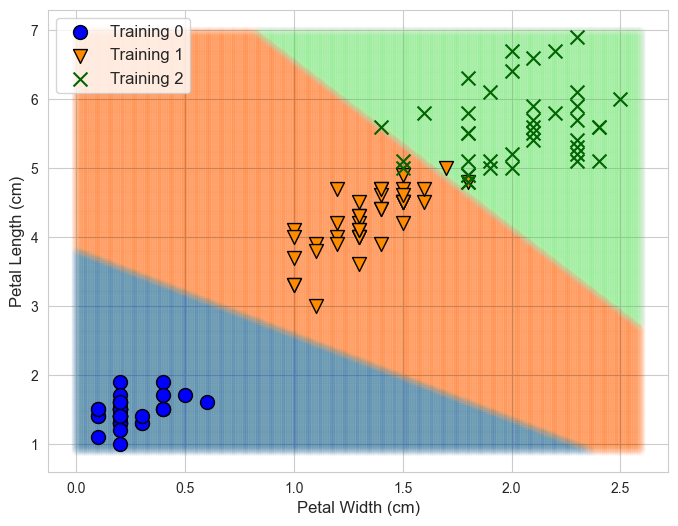

In [13]:
## Making a grid
p_width_min, p_width_max = X_train.petal_width.min()-.1, X_train.petal_width.max()+.1
p_length_min, p_length_max = X_train.petal_length.min()-.1, X_train.petal_length.max()+.1

xx1, xx2 = np.meshgrid(np.arange(p_width_min, p_width_max, .01),
                          np.arange(p_length_min, p_length_max, .01))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

preds = LDA.predict(X_pred)



## plotting the decision boundary with the training points
plt.figure(figsize=(8,6))

plt.scatter(X_pred[preds==0,0],
            X_pred[preds==0,1],
            alpha=.01)
plt.scatter(X_pred[preds==1,0],
            X_pred[preds==1,1],
            alpha=.01)
plt.scatter(X_pred[preds==2,0],
            X_pred[preds==2,1],
            alpha=.01,
            color='lightgreen')

plt.scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=100)
plt.scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                label='Training 1',
                c = 'darkorange',
                marker='v',
                edgecolor='black',
                s=100)
plt.scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                label='Training 2',
                c = 'darkgreen',
                marker = 'x',
                s=100)


plt.xlabel("Petal Width (cm)", fontsize=12)
plt.ylabel("Petal Length (cm)", fontsize=12)
plt.legend(fontsize=12, loc=2)

plt.show()

## Quadratic discriminant analysis (QDA)

In <i>quadratic discriminant analysis</i> (QDA) we relax the assumption that the covariance matrix is the same across all classes. We thus have that $X|y=c \sim N(\mu_c, \Sigma_c)$, where $\Sigma_c$ is the covariance matrix of $X|y=c$.

When we perform QDA we assign to $X^*$ the class for which:

$$
\delta_c(X^*)  = -\frac{1}{2} \left( X^* - \mu_c \right)^T \Sigma_c^{-1}  \left(X^* - \mu_c  \right) - \frac{1}{2}\log\left(|\Sigma_c| \right) + \log(\pi_c) 
$$

$$
= -\frac{1}{2} X^{*T} \sigma^{-1}_c X^* + X^{*T} \sigma^{-1}_c \mu_c - \frac{1}{2} \mu_c^T \sigma_c^{-1} \mu_c - \frac{1}{2}\log\left(|\Sigma_c| \right) + \log(\pi_c)
$$

Let's demonstrate the difference using our `iris` data set and `sklearn`.

QDA is implemented in `sklearn` with `QuadraticDiscriminantAnalysis`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html">https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html</a>.

In [14]:
## importing QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [15]:
## Make a QDA object
QDA = QuadraticDiscriminantAnalysis()

In [16]:
QDA.fit(X_train[['petal_width', 'petal_length']].values,
               y_train)

QuadraticDiscriminantAnalysis()

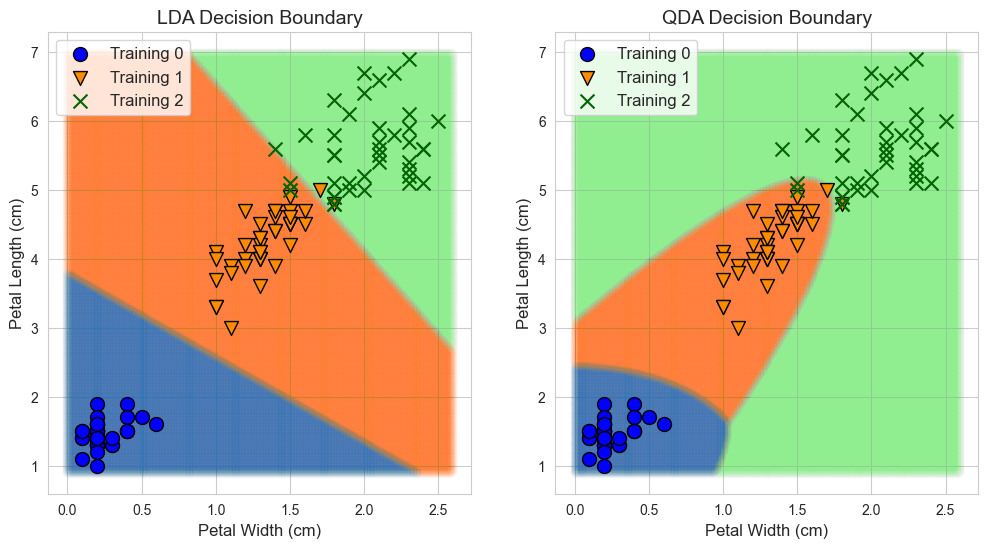

In [17]:
## Making a grid
p_width_min, p_width_max = X_train.petal_width.min()-.1, X_train.petal_width.max()+.1
p_length_min, p_length_max = X_train.petal_length.min()-.1, X_train.petal_length.max()+.1

xx1, xx2 = np.meshgrid(np.arange(p_width_min, p_width_max, .01),
                          np.arange(p_length_min, p_length_max, .01))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

LDA_preds = LDA.predict(X_pred)
QDA_preds = QDA.predict(X_pred)



## plotting the decision boundary with the training points
fig,ax = plt.subplots(1,2, figsize=(12,6))


## LDA first
### Decision Boundaries
ax[0].scatter(X_pred[LDA_preds==0,0],
            X_pred[LDA_preds==0,1],
            alpha=.01)
ax[0].scatter(X_pred[LDA_preds==1,0],
            X_pred[LDA_preds==1,1],
            alpha=.01)
ax[0].scatter(X_pred[LDA_preds==2,0],
            X_pred[LDA_preds==2,1],
            c='lightgreen',
            alpha=.01)

### Training Points
ax[0].scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=100)
ax[0].scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                label='Training 1',
                marker='v',
                c = 'darkorange',
                edgecolor='black',
                s=100)
ax[0].scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                label='Training 2',
                marker='x',
                c = 'darkgreen',
                s=100)
ax[0].set_title("LDA Decision Boundary", fontsize=14)
ax[0].set_xlabel("Petal Width (cm)", fontsize=12)
ax[0].set_ylabel("Petal Length (cm)", fontsize=12)



## QDA second
### Decision Boundaries
ax[1].scatter(X_pred[QDA_preds==0,0],
            X_pred[QDA_preds==0,1],
            alpha=.01)
ax[1].scatter(X_pred[QDA_preds==1,0],
            X_pred[QDA_preds==1,1],
            alpha=.01)
ax[1].scatter(X_pred[QDA_preds==2,0],
            X_pred[QDA_preds==2,1],
            c='lightgreen',
            alpha=.01)

### Training Points
ax[1].scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=100)
ax[1].scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                label='Training 1',
                c = 'darkorange',
                marker='v',
                edgecolor='black',
                s=100)
ax[1].scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                label='Training 2',
                c = 'darkgreen',
                marker='x',
                s=100)

ax[1].set_title("QDA Decision Boundary", fontsize=14)
ax[1].set_xlabel("Petal Width (cm)", fontsize=12)
ax[1].set_ylabel("Petal Length (cm)", fontsize=12)



ax[0].legend(fontsize=12, loc=2)
ax[1].legend(fontsize=12, loc=2)


plt.show()

As we can see a key difference between LDA and QDA as classifiers is the shape of the decision boundary. 

- The LDA decision boundary is restricted to linear separation. 
    - In 2-D this means that our feature plane is split using lines, in 3-D planes, in higher dimensions hyperplanes. 
- The QDA decision boundary can be nonlinear, which gives it more flexibility.

Recalling our bias-variance tradeoff, LDA has more bias, while QDA has more variance. The one that you want depends on your data set. In this example I think the LDA model would better generalize to additional iris observations.

#### LDA vs QDA

##### When LDA

- LDA works better than QDA for smaller data sets, because we don't have to estimate as many parameters
    - This is because of the $\Sigma$ assumption, here we only have to estimate $m(m+1)/2$ covariances, while in QDA you have to estimate $\mathcal{C} m (m+1)/2$
- LDA works better if you think your data can be mostly separated by linear decision boundaries. This can be guessed at by examining the training data

##### When QDA

- QDA needs a large data set to properly fit
    - See above argument
- QDA is preferable to LDA if you suspect that the data is better separated by a nonlinear decision boundary.

## Na&#xEF;ve Bayes classifier

Recall that we are using Bayes' rule to estimate $P(y=c|X)$:

$$
P(y=c|X=X^*) = \frac{\pi_c f_c(X^*)}{\sum_{l=1}^\mathcal{C} \pi_l f_l(X^*)}.
$$

In order to make this estimate we have to:
- estimate $\mathcal{C}$ $\pi_c$s:
    - this is straightforward
- estimate $\mathcal{C}$ $m$-dimensional density functions, $f_c(X)$
    - not so straightforward
    
In LDA and QDA we make strong assumptions regarding the form of the density functions. This allows us to take a hard estimation problem, and turn it into a much easier estimation problem. However, these are strong assumptions that could be way off.

### Assuming independence

The na&#xEF;ve Bayes classifier takes a different approach. Instead of assuming a set form for the density we instead assume that within a given class, $c$, each of $m$ features are independent. That allows us to write:

$$
f_c(X) = f_{c_1}(X_1) \times f_{c_2}(X_2) \times \dots \times f_{c_m}(X_m),
$$

where $f_{c_j}(X_j)$ denotes the probability density function for $X_j$ among observations of the $c^\text{th}$ class.

Under this assumption we have:

$$
P(y=c|X=X^*) = \frac{\pi_c f_{c_1}(X_1^*) \times f_{c_2}(X_2^*) \times \dots \times f_{c_m}(X_m^*)}{\sum_{l=1}^\mathcal{C} \pi_l f_{l_1}(X_1^*) \times f_{l_2}(X_2^*) \times \dots \times f_{l_m}(X_m^*)}.
$$

Assuming independence between the feature variables allows us to turn our difficult problem of estimating an $m$-dimensional probability distribution (which involves estimating both $m$ marginal distributions and a joint distribution) into a problem where we just have to estimate $m$ independent probability distributions, which is much more tractable.

### Estimating the $f_{c_j}$

When it comes to estimating the $f_{c_j}$ we typically assume some kind of distribution and then estimate the parameters for that distribution accordingly.

For example:
- if $X_j$ is quantitative we typically assume it is a normal distribution
    - note this is different than LDA or QDA because those do not assume independence, hence the covariance matrices $\Sigma$ or $\Sigma_c$.
- if $X_j$ is categorical we could just use a Bernouli distribution (think biased coin toss) estimating the value of $p$ using the proportion of observations where $y=c$ for each possible value of $X_j$.

### Is independence a good assumption?

Assuming independence is not always a <i>good</i> assumption in the sense that the some of the features may in fact be related to one another. However, even if this assumption does not hold, we can still get decent to good classifiers using na&#xEF;ve Bayes. This can be particularly true if we do not have enough data to reasonably estimate a joint probability distribution. We can think of this assumption as adding bias to our model.

Let's show how to implement this algorithm in `sklearn` with the `iris` data set.

Na&#xEF;ve Bayes is implemented in `sklearn` with a few different methods, all found in the `naive_bayes` module, <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes">https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes</a>.

Because the two features we will use are quantitative we will use the `GaussianNB` model, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html">https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html</a>.

In [18]:
## import GaussianNB
from sklearn.naive_bayes import GaussianNB

In [19]:
## Make the model
nb = GaussianNB()

## Fit the model
nb.fit(X_train[['petal_width', 'petal_length']].values,
          y_train)

GaussianNB()

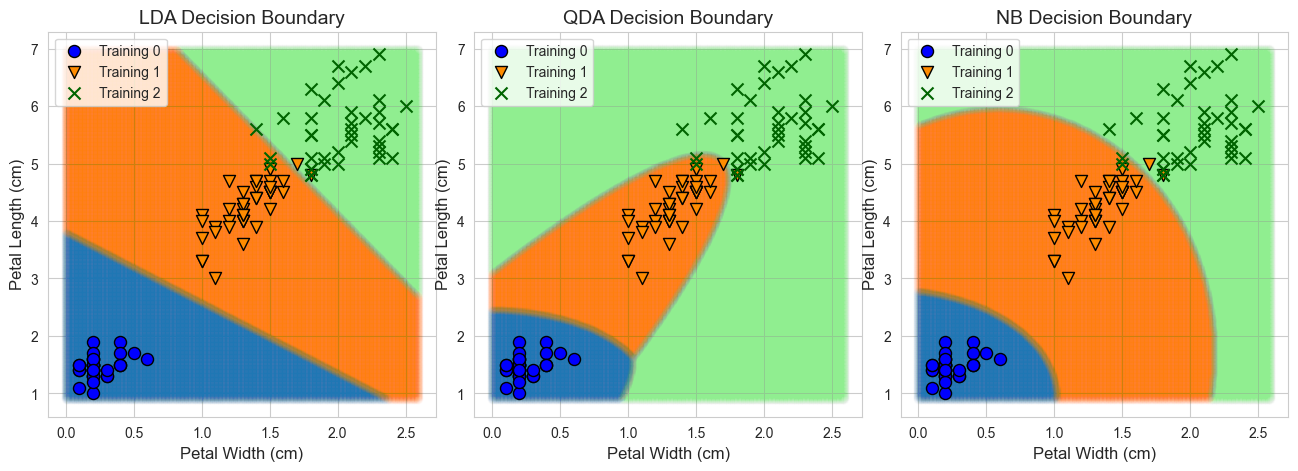

In [20]:
s = 75

## Making a grid
p_width_min, p_width_max = X_train.petal_width.min()-.1, X_train.petal_width.max()+.1
p_length_min, p_length_max = X_train.petal_length.min()-.1, X_train.petal_length.max()+.1

xx1, xx2 = np.meshgrid(np.arange(p_width_min, p_width_max, .01),
                          np.arange(p_length_min, p_length_max, .01))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

LDA_preds = LDA.predict(X_pred)
QDA_preds = QDA.predict(X_pred)
NB_preds = nb.predict(X_pred)



## plotting the decision boundary with the training points

## make the subplots
fig,ax = plt.subplots(1,3,figsize=(16,5))

## Plot the LDA first
### Decision Boundaries
ax[0].scatter(X_pred[LDA_preds==0,0],
            X_pred[LDA_preds==0,1],
            alpha=.01)
ax[0].scatter(X_pred[LDA_preds==1,0],
            X_pred[LDA_preds==1,1],
            alpha=.01)
ax[0].scatter(X_pred[LDA_preds==2,0],
            X_pred[LDA_preds==2,1],
            c = 'lightgreen',
            alpha=.01)

### Training Data
ax[0].scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=s)
ax[0].scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                label='Training 1',
                c = 'darkorange',
                marker = 'v',
                edgecolor='black',
                s=s)
ax[0].scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                label='Training 2',
                c = 'darkgreen',
                marker = 'x',
                s=s)
ax[0].set_title("LDA Decision Boundary", fontsize=14)
ax[0].set_xlabel("Petal Width (cm)", fontsize=12)
ax[0].set_ylabel("Petal Length (cm)", fontsize=12)

## Plot the QDA next
### Decision boundaries
ax[1].scatter(X_pred[QDA_preds==0,0],
            X_pred[QDA_preds==0,1],
            alpha=.01)
ax[1].scatter(X_pred[QDA_preds==1,0],
            X_pred[QDA_preds==1,1],
            alpha=.01)
ax[1].scatter(X_pred[QDA_preds==2,0],
            X_pred[QDA_preds==2,1],
            c = 'lightgreen',
            alpha=.01)

### The training data
ax[1].scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=s)
ax[1].scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                label='Training 1',
                c = 'darkorange',
                marker = 'v',
                edgecolor='black',
                s=s)
ax[1].scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                label='Training 2',
                c = 'darkgreen',
                marker = 'x',
                s=s)

ax[1].set_title("QDA Decision Boundary", fontsize=14)
ax[1].set_xlabel("Petal Width (cm)", fontsize=12)
ax[1].set_ylabel("Petal Length (cm)", fontsize=12)


## Plot the naive bayes finally
### Decision Boundaries
ax[2].scatter(X_pred[NB_preds==0,0],
            X_pred[NB_preds==0,1],
            alpha=.01)
ax[2].scatter(X_pred[NB_preds==1,0],
            X_pred[NB_preds==1,1],
            alpha=.01)
ax[2].scatter(X_pred[NB_preds==2,0],
            X_pred[NB_preds==2,1],
            c = 'lightgreen',
            alpha=.01)

### Training data
ax[2].scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                label='Training 0',
                c = 'blue',
                edgecolor='black',
                s=s)
ax[2].scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                label='Training 1',
                c = 'darkorange',
                marker = 'v',
                edgecolor='black',
                s=s)
ax[2].scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                label='Training 2',
                c = 'darkgreen',
                marker = 'x',
                s=s)

ax[2].set_title("NB Decision Boundary", fontsize=14)
ax[2].set_xlabel("Petal Width (cm)", fontsize=12)
ax[2].set_ylabel("Petal Length (cm)", fontsize=12)




ax[0].legend(fontsize=10, loc=2)
ax[1].legend(fontsize=10, loc=2)
ax[2].legend(fontsize=10, loc=2)

plt.subplots_adjust(wspace=.1)


plt.show()

As we can see the na&#xEF;ve Bayes classifier still allows for non-linear boundaries, and by introducing some bias we may even produce a model that generalized better than say the QDA model.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)